In [ ]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data.loader import load_prices, compute_returns

# === Funções da Regressão Linear (walk-forward) ===
from src.models.lr import (
    predict_daily_series_lr,
    expected_return_from_predictions,
    evaluate_prediction_series,
)

# === Funções da RNN (avaliação) ===
from src.models.rnn import (
    evaluate_rnn_model,   # usa prices + série prevista
)

from outputs.charts.markowitz_plot import compare_time_series, compare_frontiers
from outputs.charts.models_markowitz import (
    plot_LR_parity_return_prediction,
    plot_LR_parity_by_all_assets,
)

In [2]:
tickers = [
    "PETR4.SA", "VALE3.SA", "ITUB4.SA", "BBDC4.SA",
    "BBAS3.SA", "ABEV3.SA", "WEGE3.SA", "B3SA3.SA", "GGBR4.SA"
]

start_date = "2017-01-01"
end_date = "2025-06-01"

prices = load_prices(tickers, start=start_date, end=end_date)

/workspaces/deep_learning_finance/src/data/loader.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  9 of 9 completed


In [3]:
returns_daily = compute_returns(prices, freq="daily")
pure_daily = returns_daily.mean()
cov_daily = returns_daily.cov()

returns_monthly = compute_returns(prices, freq="monthly")
pure_monthly = returns_monthly.mean()
cov_monthly = returns_monthly.cov()

In [ ]:
pred_lr_series = pd.read_csv(
    "../outputs/predictions/lr_daily_series.csv",
    index_col=0,
    parse_dates=True
)
mu_lr_daily, mu_lr_month = expected_return_from_predictions(pred_lr_series)

print("Resumo das médias diárias previstas (LR):")
display(mu_lr_daily.describe())

Resumo das médias diárias previstas (LR rolling):


count     9.000000
unique    9.000000
top      -0.000099
freq      1.000000
dtype: float64

In [ ]:
pred_rnn_series = pd.read_csv(
    "../outputs/predictions/rnn_daily_series.csv",
    index_col=0,
    parse_dates=True
)
mu_rnn_daily, mu_rnn_month = expected_return_from_predictions(pred_rnn_series)

print("Resumo das médias diárias previstas (RNN):")
display(mu_rnn_daily.describe())

FileNotFoundError: [Errno 2] No such file or directory: '../outputs/predictions/rnn_daily_series.csv'

In [ ]:
models = [
    {
        "name": "Markowitz Diário (Histórico)",
        "mean_returns": pure_daily,
        "cov": cov_daily,
        "is_monthly": False,
        "color": "blue",
        "linestyle": "-"
    },
    {
        "name": "Regressão Linear (walk-forward)",
        "mean_returns": mu_lr_daily,
        "cov": cov_daily,
        "is_monthly": False,
        "color": "orange",
        "linestyle": "--"
    },
    {
        "name": "RNN (walk-forward)",
        "mean_returns": mu_rnn_daily,
        "cov": cov_daily,
        "is_monthly": False,
        "color": "purple",
        "linestyle": "--"
    },
    {
        "name": "Markowitz Mensal REAL",
        "mean_returns": pure_monthly,
        "cov": cov_monthly,
        "is_monthly": True,
        "color": "green",
        "linestyle": "-"
    }
]


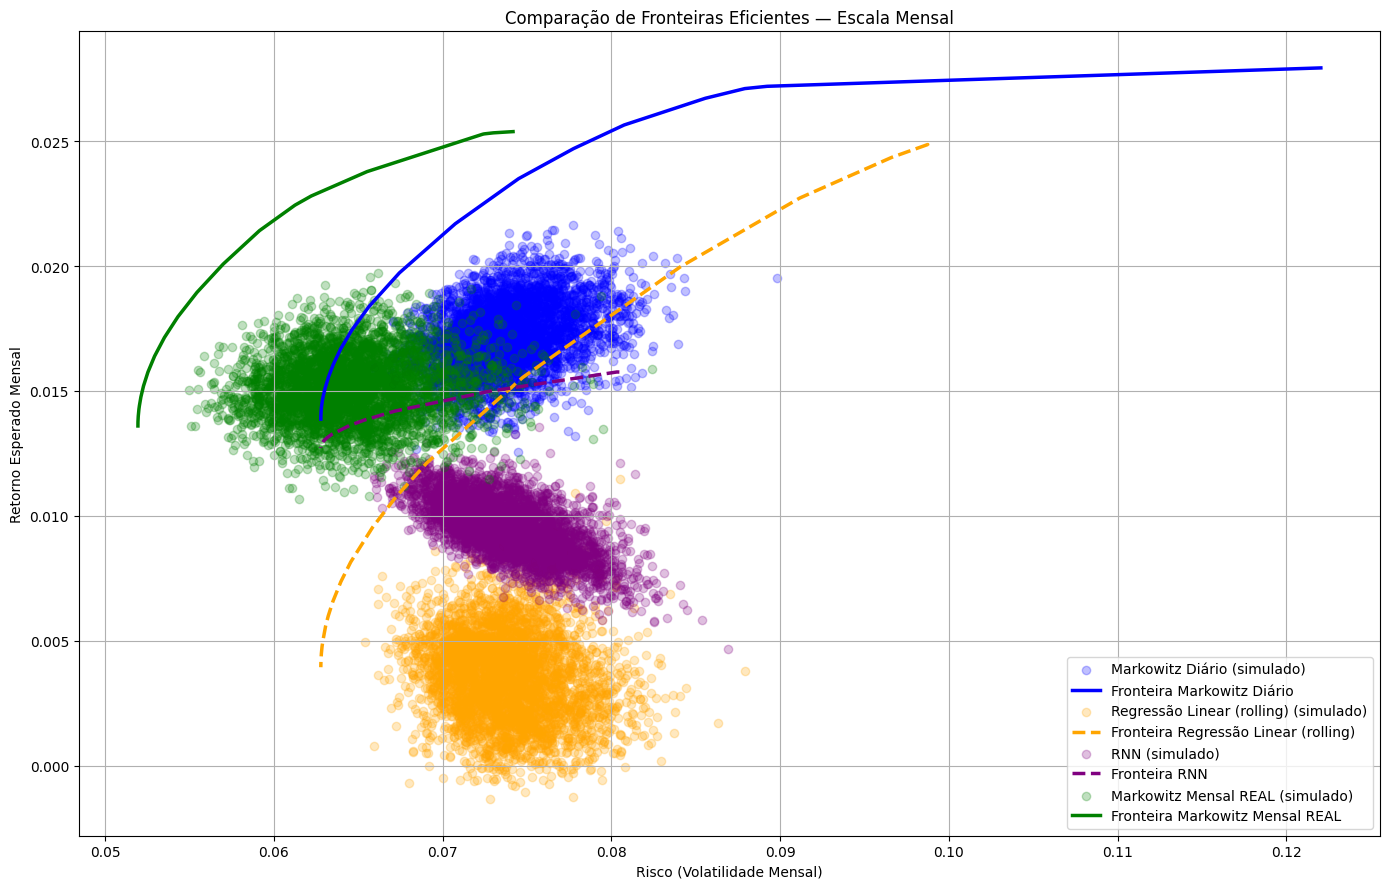

In [ ]:
compare_frontiers(models)


0.0 Markowitz Diário 0.12204221300733509 0.027928280242541795
0.0 Regressão Linear (rolling) 0.0987476829809237 0.024861343761974013
0.0 RNN 0.0804754926577019 0.015756262025810593
0.0 Markowitz Mensal REAL 0.07417454499239853 0.025378098759059636


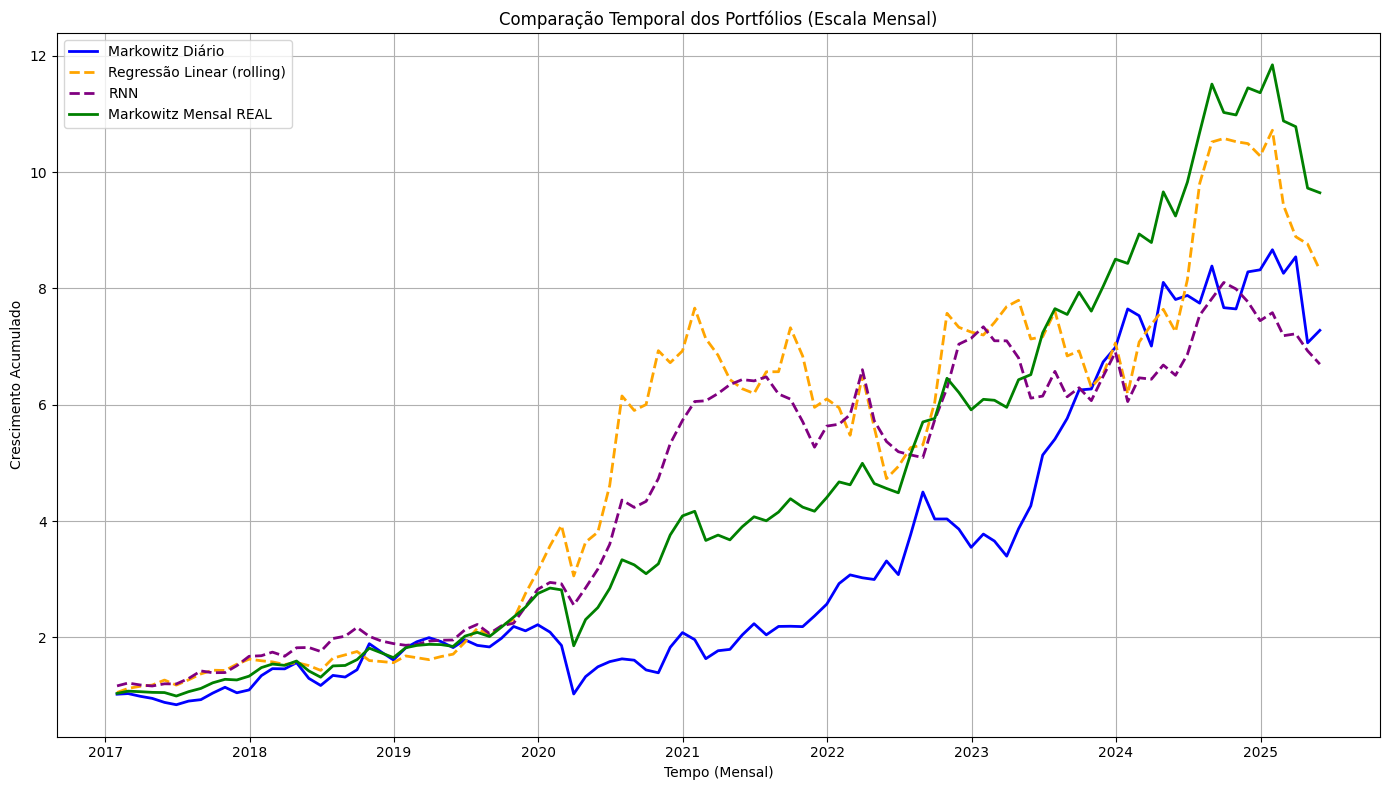

In [ ]:
compare_time_series(returns_daily, models, target_risk=0.10)

In [ ]:
eval_lr  = evaluate_prediction_series(returns_daily, pred_lr_series)
eval_rnn = evaluate_rnn_model(prices, pred_rnn_series)


/workspaces/deep_learning_finance/src/models/lr.py:85: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  preds[col].iloc[min_train:] = y_pred_list
/workspaces/deep_learning_finance/src/models/lr.py:85: FutureWarning: ChainedAssignmentError: beha

ValueError: Input contains infinity or a value too large for dtype('float64').

,Model,Mean,Volatility,Sharpe,Cumulative_Return
0,standard_markowitz,0.000687,0.013731,0.793843,2.448597
0,linear_metrics,0.000692,0.013750,0.799253,2.487241
0,rnn_metrics,0.000781,0.014041,0.882484,3.159481


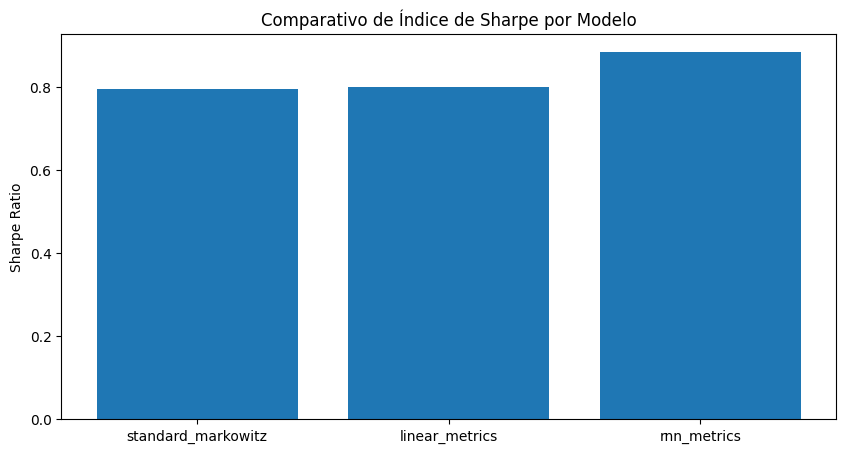

In [ ]:
files = [
    "../outputs/models/standard_markowitz.csv",
    "../outputs/models/linear_metrics.csv",
    "../outputs/models/rnn_metrics.csv",
]

df_results = pd.concat([pd.read_csv(f) for f in files])
display(df_results)

plt.figure(figsize=(10, 5))
plt.bar(df_results["Model"], df_results["Sharpe"])
plt.title("Comparativo de Índice de Sharpe por Modelo")
plt.ylabel("Sharpe Ratio")
plt.show()


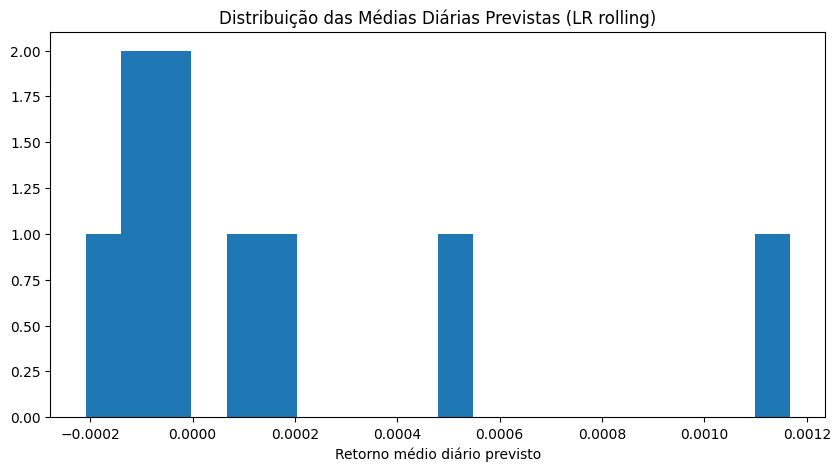

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(mu_daily_lr, bins=20)
plt.title("Distribuição das Médias Diárias Previstas (LR rolling)")
plt.xlabel("Retorno médio diário previsto")
plt.show()



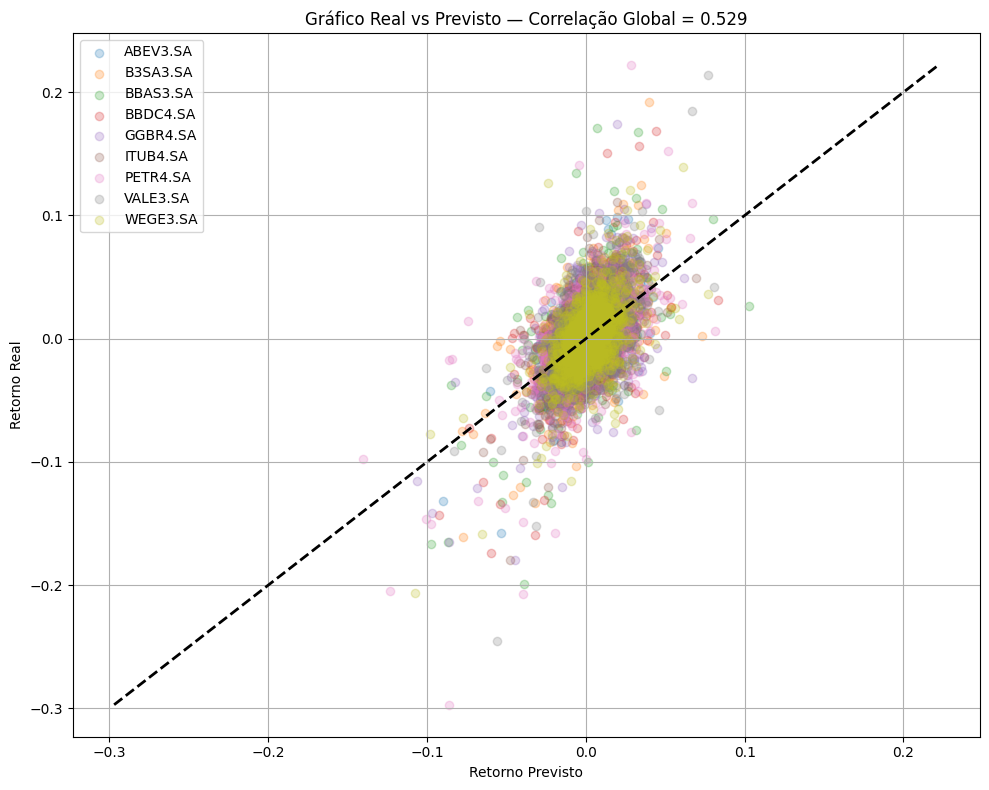

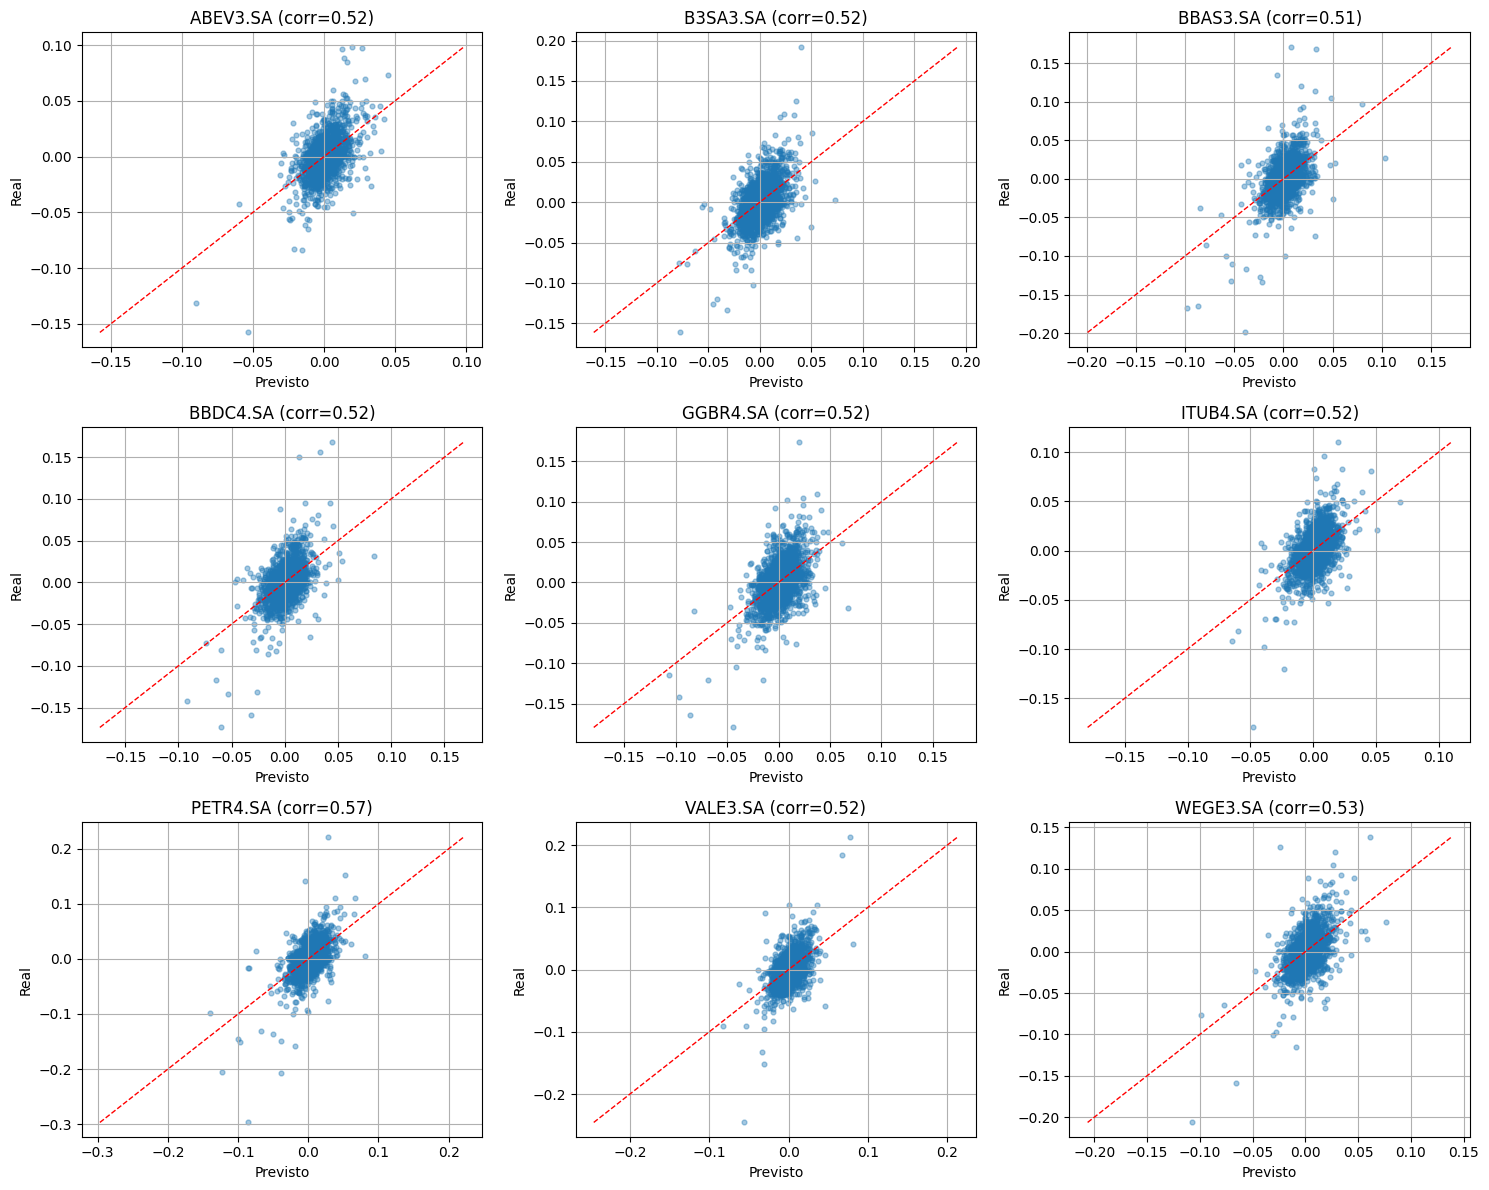

In [ ]:
plot_LR_parity_return_prediction(prices, window=5)
plot_LR_parity_by_all_assets(prices, window=5)
